In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import Math, display
plt.style.use("light")
plt.rcParams["font.size"] = 8

def printf(expr, prefix=""):
    """Function to print sympy nice

    Args:
        expr (sympy.expr): Any sympy expression
        prefix (str, optional): Prefix to expression in LaTeX. Defaults to "".
    """
    display(Math(prefix + sp.latex(expr)))

# Fundamental of Simulation Methods
**Name**: Maximilian Richter

**Matrikel Number**: 3463789

**Student ID**: hy455

## Problem Set 3: ODE, comparison of different integrators

### 1. Orbit of two objects

(a) The energy conditions for different orbits can be derived from the total energy $$E(r) = \frac{m}{2}\dot{r}^2 + U(r)$$ of a particle in the gravitational potential of the two body problem $$U(r)=\frac{L^2}{2mr^2}-G\frac{mM}{r}$$
- **Elliptic**: $E < 0$
- **Parabolic**: $E = 0$
- **Hyperbolic**: $E > 0$

(b) We get the initial velocities for a circular orbit if the total energy is equal to the minimum of the potential energy. As the initial velocity accounts for the angular momentum, we can rewrite the potential energy with $L=rmv$ and find the minimum of the potential energy by differentiation and solving for $v$

In [2]:
r, L,m, M, G, v = sp.symbols("r, L, m, M, G,v")

# Potential energy
U = L**2/(2*m*r**2)-m*M*G/r

# Derivative w.r.t position and substitute angular momentum
dU = U.diff(r).subs(L, r*m*v)

# Solve for velocity
v0 = sp.solve(dU, v)

printf(v0[0], "v_{0,1}=")
printf(v0[1], "v_{0,2}=")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The direction of the velocity vector has to be perpendicular to the position vector

### 2. Integration of the Orbit

In [3]:
def force(y0):
    """Calculate the gravitational force for G=1, m=1, M=1

    Args:
        y0 (Tuple): State vector

    Returns:
        np.array: Velocities and acceleration
    """
    x, y, vx, vy = y0
    r = np.sqrt(x**2+y**2)
    return np.array([vx, vy, -x/r**3, -y/r**3])

def integrate(f, y0, t, dt, method="Euler"):
    """Integrate ODE with different methods

    Args:
        f (callable): Ordinary differential equation
        y0 (Tuple): Initial State
        t (float): Time to simulate
        dt (float): Step size
        method (str, optional): Method to integrate ode. Choose between "Euler", 
        "RK4" and "Leapfrog". Defaults to "Euler".

    Returns:
        np.array: Solution matrix
    """
    steps = int(t/dt)
    solution = [y0]

    if method=="Euler":
        for n in range(steps):
            y0 = y0 + dt*f(y0)
            solution.append(y0)

    if method=="RK4":
        for n in range(steps):
            k1 = f(y0)
            k2 = f(y0 + k1 * dt/2)
            k3 = f(y0 + k2 * dt/2)
            k4 = f(y0 + k3 * dt)

            y0 = y0 + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
            solution.append(y0)

    if method=="Leapfrog":
        x, y, vx, vy = y0
        for n in range(steps):
            x = x + vx*dt
            y = y + vy*dt
            vx = vx + f((x,y,vx,vy))[2]*dt
            vy = vy + f((x,y,vx,vy))[3]*dt
            y0 = x, y, vx, vy
            solution.append(y0)
    
    return np.array(solution)

## (a) Initialize an orbiter on a bound (elliptic) orbit

In [4]:
y0 = np.array([1,0,0.5,1]) # x,y,vx,vy
t = 100
dt = 0.1

sol_euler = integrate(force, y0, t, dt, "Euler")
sol_rk4 = integrate(force, y0, t, dt, "RK4")
sol_leapfrog = integrate(force, y0, t, dt, "Leapfrog")

In [5]:
def plot_solution(sol, title):
    extent = 1.1*np.max(np.abs(sol[:,:2]))

    plt.figure(figsize=(5,5))
    plt.plot(sol[:,0], sol[:,1], linewidth=0.5)

    plt.xlim(-extent, extent)
    plt.ylim(-extent, extent)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()

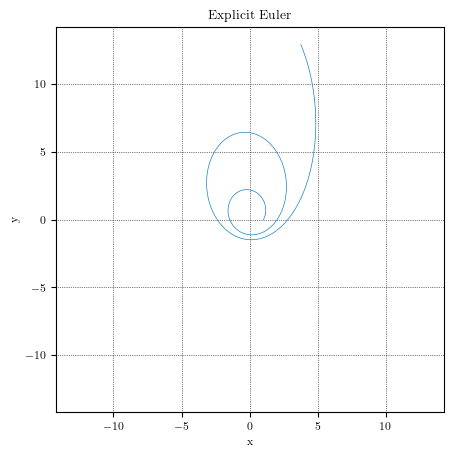

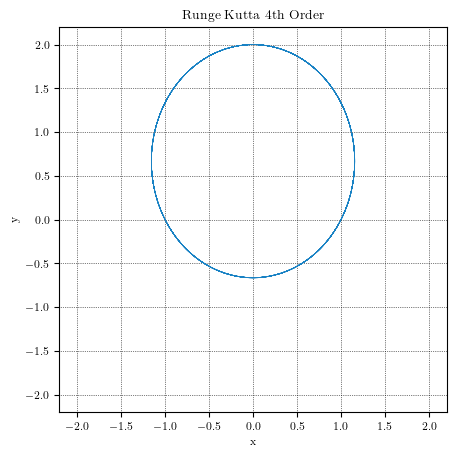

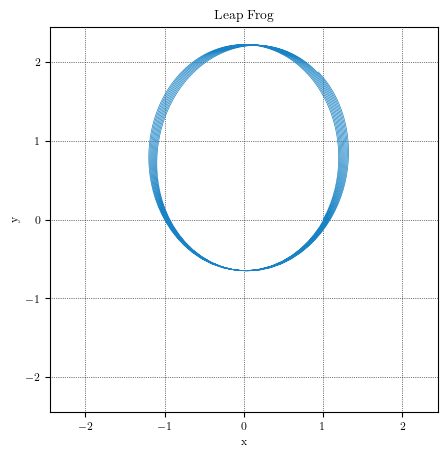

In [6]:
plot_solution(sol_euler, "Explicit Euler")
plot_solution(sol_rk4, "Runge Kutta 4th Order")
plot_solution(sol_leapfrog, "Leap Frog")

## (b) Compare the accuracy. How does the energy change?

In [7]:
def get_energy(sol):
    x,y, vx, vy = sol[:,0],sol[:,1],sol[:,2],sol[:,3]
    r = np.sqrt(x**2+y**2)
    v_squared = vx**2+vy**2
    return v_squared - 1/r

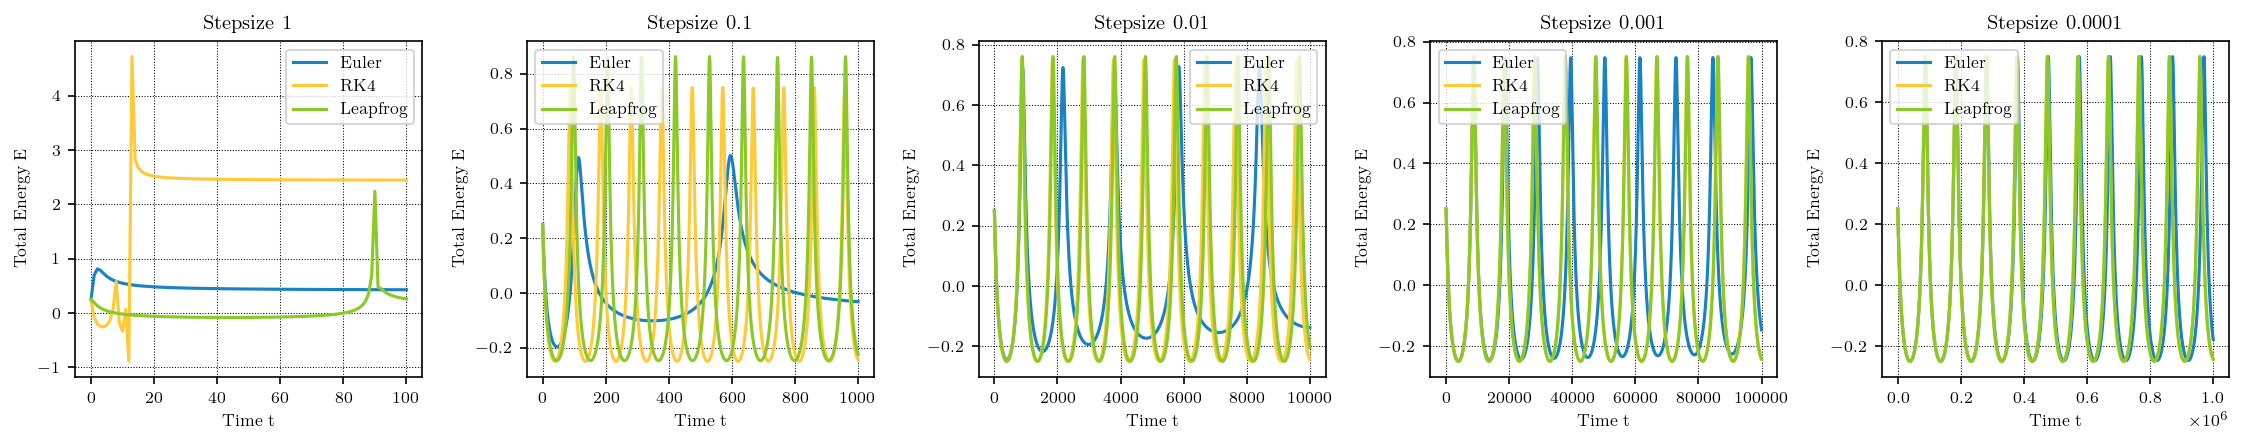

In [8]:
dt_list = [10**(-i) for i in range(0,5)]

fig, ax = plt.subplots(1,5, figsize=(15,3), dpi=150)
for i in range(5):
    dt = dt_list[i]
    sol_euler = integrate(force, y0, t, dt, "Euler")
    sol_rk4 = integrate(force, y0, t, dt, "RK4")
    sol_leapfrog = integrate(force, y0, t, dt, "Leapfrog")

    energy_euler = get_energy(sol_euler)
    energy_rk4 = get_energy(sol_rk4)
    energy_leapfrog = get_energy(sol_leapfrog)

    ax[i].plot(energy_euler, label="Euler")
    ax[i].plot(energy_rk4, label="RK4")
    ax[i].plot(energy_leapfrog, label="Leapfrog")
    ax[i].set_title(f"Stepsize {dt}")
    ax[i].set_xlabel("Time t")
    ax[i].set_ylabel("Total Energy E")
    ax[i].legend()
plt.tight_layout()


The resulting plot shows that with a step size of 1 all integrators fail to integrate the ODE. By decreasing the step size the leap frog and the Runge Kutta 4th Order integrators are able to get (more or less) stable orbits while the Euler scheme fails to conserve the energy, even for very small step sizes. For very small step sizes leap frog and Runge Kutta are almost identical. However, the Leap frog is a much simpler algorithm with less arithmetic operations, thus faster.

## (c) Systematic Energy Changes for the Euler Integrator
The Orbit changes only in one direction because as a first order method it accumulates errors in energy linearly. Especially when the forces / the acceleration gets large, the error is large as well. This always happens systematically when the orbiter approaches the perihelion or the ellipse. Because of the bad approximation the orbiter gets boosted much more than it would in a physical situation. This leads to a gain in energy and therefore a larger orbit until it leaves the orbit and travels away to infinity.

## (d) Compare RK4 Method with Leap Frog Scheme

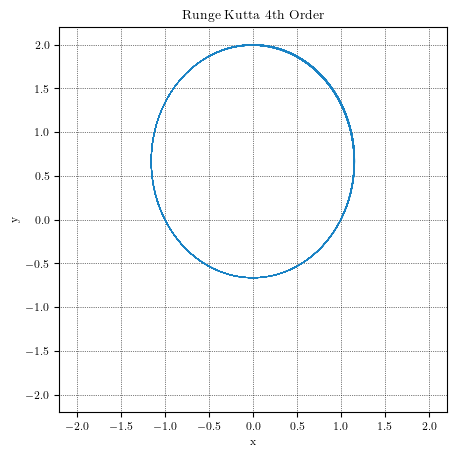

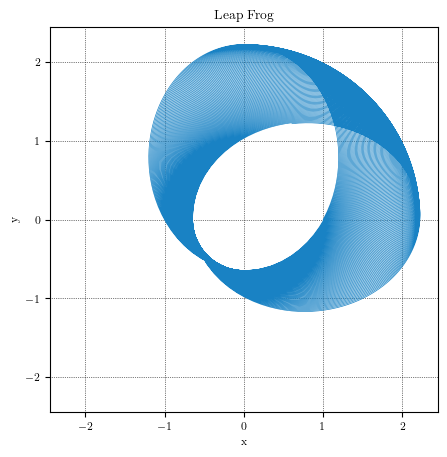

In [9]:
t = 1000
dt = 0.1

sol_rk4 = integrate(force, y0, t, dt, "RK4")
sol_leapfrog = integrate(force, y0, t, dt, "Leapfrog")

plot_solution(sol_rk4, "Runge Kutta 4th Order")
plot_solution(sol_leapfrog, "Leap Frog")

The Runge Kutta 4th Order method appears to be much more accurate over a long time, even with quite a large step size. For one orbit the Leap frog still delivers reasonable results and is much cheaper to compute. 